<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/1_understanding_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. How do they work? - understanding Random Forest

Welcome to this CodeGEO Workshop, where you will learn about Random Forest. Don’t worry, we’re not in biology class! Random Forest has become one of the most popular Machine Learning algorithms thanks to its versatility and ease of use. In this workshop you will learn the basics of how this algorithm works and what its hyperparameters mean, so you can interpret its results correctly and tailor your model to achieve the best performance.

## 1.1 Task preparation

### Objective and dataset

Our goal this time is to predict the water level at the Hagestein station using a selection of five meteorological and hydrological variables: the discharge of the Rhine and Meuse at the Dutch border, the water level of the North Sea, precipitation and evaporation.

- **Dataset**: We have daily measurements of the described variables spanning from 1981 to 2019. For more information about the data sources, we encourage you to check [Hauswirth et al. (2021)](https://doi.org/10.1016/j.advwatres.2021.104017).

![picture](https://drive.google.com/uc?export=view&id=1gLk7NO1tvM9cLj-JMgG8eEaNXHw_DWVl)

*Door Rijksdienst voor het Cultureel Erfgoed, CC BY-SA 4.0, https[]()://commons.wikimedia.org/w/index.php?curid=24032939*

### Importing libraries

As in the previous time, we start by importing the necessary libraries, which you should already be familiar with by now! We will import the specific functions that we need from sklearn later. We are also adding **numpy** to the collection, one of the most common libraries for scientific computing in Python that makes working with n-dimensional arrays much easier and faster.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Preparing the data

The clean data can be retrieve from GitHub. Our output, the water level, is stored in the value column. The discharge at the Rhine (QRhine) and Meuse (QMeuse), water level at the North Sea (WLHv), precipitation (RH) and evaporation (EV24) are also included.

In [4]:
data_url =  "https://raw.githubusercontent.com/Jignesh1594/CodeGeoworkshop_02_understanding_RF/master/data.csv"
data = pd.read_csv(data_url, delimiter=",", on_bad_lines='skip')

input_data = data[['WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine']]
output_data = data[['value']]

As always, we check the data to check that everything went fine (we join input and output to visualize them together). The data has already been cleaned for you, so we can move on directly to the topic for today.

In [5]:
input_data.join(output_data).head()

,WLHv,RH,EV24,QMeuse,QRhine,value
0,-18.395833,1.0,24.0,290.0,2579.0,269.72
1,-3.223881,177.0,23.0,167.0,1914.0,290.68
2,-13.020833,46.0,17.0,158.0,1864.0,289.52
3,2.618056,77.0,23.0,144.0,1777.0,287.88
4,5.812500,43.0,17.0,151.0,1759.0,290.92


We also perform a train/test split, with 90% of the data for training and the remaining 10% for testing. For more details check the *Training your first ML model* workshop.

In [6]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(input_data, output_data, test_size = 0.1, shuffle=False)

## 1.2 Obtaining our building blocks

### Visualizing decision trees

Wait, decision trees? I thought we were here to learn about Random Forest. Well, actually RF is what is known as an ensamble method. These methods combine multiple "weak" models to produce strong predictions. In the case of RF, these simple ML models are no other than decision trees!

Decision trees make binary decisions on the input variables hierarchically, ultimately leading to multiple possible outcomes for the target variable. These decisions are found automatically by minimizing the loss function on the data. To get a better idea of what that means, we will start by generating a decision tree on a subset of the training data and visualize it. To keep the output concise, we will limit the amount of leaf nodes (i.e. possible outcomes) that the tree can have with the `max_leaf_nodes` parameter.

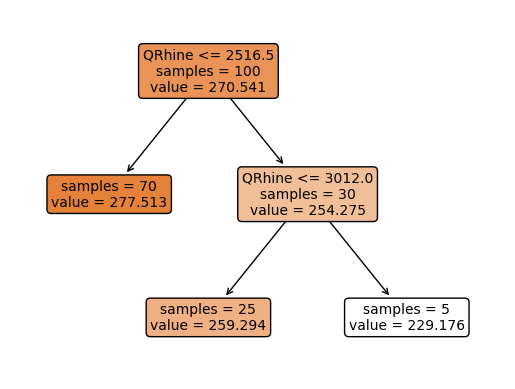

In [7]:
from sklearn.tree import DecisionTreeRegressor

# Subset the data to only include the first 100 rows
X_train_subset = X_train.iloc[:100]
y_train_subset = y_train.iloc[:100]

# Fit the decision tree to the data
simple_tree = DecisionTreeRegressor(max_leaf_nodes = 3, random_state = 42)
simple_tree.fit(X_train_subset.values, y_train_subset.values.ravel())

from sklearn.tree import plot_tree

# Plot the decision tree
tree_plot = plot_tree(simple_tree, feature_names = input_data.columns,
                      fontsize = 10, impurity=False, rounded=True, filled=True)
plt.show()

Let's try to understand the **trees growth**. The algorithm starts from top to bottom, selecting each time the split in the data that gets the lowest error, in this case MSE, in the resulting predictions. For each node, we can see the amount of samples in each of them and the predicted water level value. We can recognize the decision nodes (or split nodes), because they also include a boolean statement involving one of the predictor variables. Once we finish splitting the data, be it because there is no more data or due to pruning (as we have done by limiting *max_leaf_nodes*) we end up at the leave notes, which represent the possible outcomes of the model.

In this case, the discharge in the Rhine was selected for both decision nodes, meaning it is the variable that is better suited to predict the water level. This makes sense, as most of the water at the measurement location will be coming from the Rhine. Let's see how these nodes look if we plot the data.

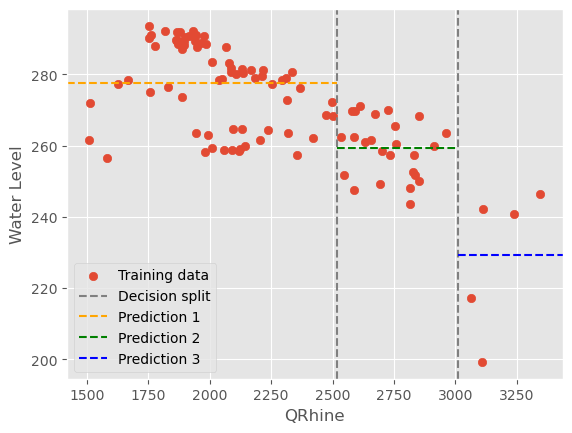

In [8]:
# Customize the style of the plot
from matplotlib import style
style.use('ggplot')

# Plot the values of the target variable against QRhine
plt.scatter(X_train_subset['QRhine'], y_train_subset, label='Training data')
plt.xlabel('QRhine')
plt.ylabel('Water Level')

# Plot vertical lines to indicate the decision node boundaries of the decision tree
splits = sorted(simple_tree.tree_.threshold[simple_tree.tree_.threshold > 0])
for i, split in enumerate(splits):
    if i == 0:
        plt.axvline(split, color='grey', linestyle='--', label='Decision split')
    else:
        plt.axvline(split, color='grey', linestyle='--')

# Get the current x-axis limits
xmin, xmax = plt.xlim()

# Get predicted values of the leaf nodes
leaf_indices = simple_tree.tree_.children_left == -1
leaf_values = simple_tree.tree_.value[leaf_indices, 0, 0]

# Plot the horizontal lines
plt.hlines(leaf_values[0], xmin=xmin, xmax=splits[0], color='orange', linestyle='--', label='Prediction 1')
plt.hlines(leaf_values[1], xmin=splits[0], xmax=splits[1], color='green', linestyle='--', label='Prediction 2')
plt.hlines(leaf_values[2], xmin=splits[1], xmax=xmax, color='blue', linestyle='--', label='Prediction 3')

# Reset the x-axis limits and finish plot
plt.xlim(xmin, xmax)
plt.legend()
plt.show()

This plot is crucial to understand how decision trees work. Here we have plotted the water level (predicted variable) against the QRhine (predictor variable) for the training data, to see how decision trees compartimentalize the predictor space to make predictions.

The tree has split the data twice based on a threshold for the QRhine variable, as we can see in the **decision nodes**. If you check the position of the decision splits in the X axis, you will see that they coincide with the thresholds of the decision nodes in the tree schematic above. As we have seen, the choice of what variable to split and at what threshold is made by minimizing the error at each split hierarchically.

Every area in the predictor space created by the decision splits correspond to each of the **leaf nodes**. Because we only have one predictor variable it is only different range of values in QRhine, but if we had more the predictor space would be splitted in hyperrectangles. Then, the decision tree averages the data in each of these areas, and that becomes the prediction for that range of values. Again, if we check the predictions in each area, you will see that they correspond with the 'value' of the leaf nodes in the tree schematic above.

That was a very nice explanation, but let's actually see how do decision trees perform in practice.

### Predicting with fully grown trees

This time we will use all of the training data and we will not prune our tree, so we let it grow as much as it can. This means that the model will keep spliting until there is a single sample per node leaf, so we cannot split further. This is already too large a tree to properly plot it, but just to get an idea we will plot the depth of the tree and number of leaf nodes. You can check that the number of leaves should be exactly the same as the size of the training data.

In [11]:
# Train fully grown tree on all of the training data
fully_grown_tree = DecisionTreeRegressor(random_state = 42)
fully_grown_tree.fit(X_train.values, y_train.values.ravel())

# Print the depth and number of leaves of the fully grown tree
print('Depth of fully grown tree:', fully_grown_tree.get_depth())
print('Number of leaves in fully grown tree:', fully_grown_tree.get_n_leaves())

Depth of fully grown tree: 40
Number of leaves in fully grown tree: 11856


While fully growing the tree enables it to learn more complex patterns, it also makes it susceptible to outliers and it largely looses generalization power. To exemplify this, we will plot the predictions of the model for the data used for training and testing, and compare it to our simple tree.

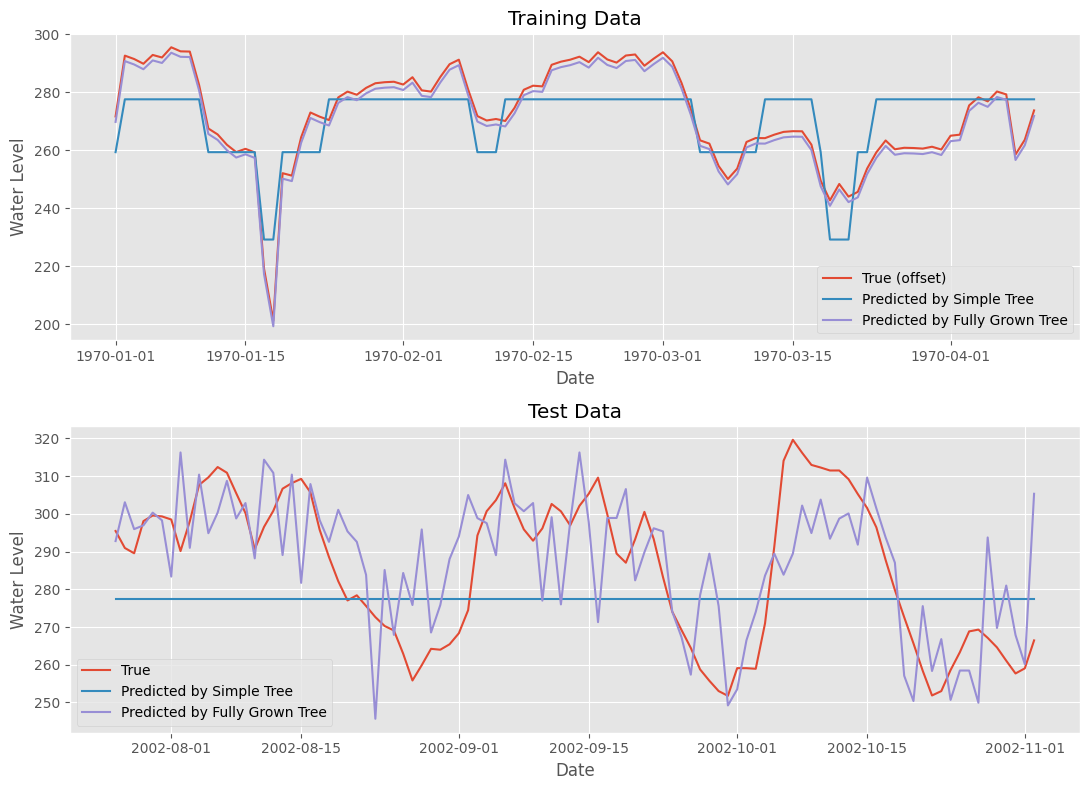

In [12]:
import matplotlib.dates as mdates

# Subset the test data to only include the first 100 rows
X_test_subset = X_test.iloc[:100]
y_test_subset = y_test.iloc[:100]

# Predict water levels for training and test data using both models
y_pred_train_simple = simple_tree.predict(X_train_subset.values)
y_pred_test_simple = simple_tree.predict(X_test_subset.values)
y_pred_train_full = fully_grown_tree.predict(X_train_subset.values)
y_pred_test_full = fully_grown_tree.predict(X_test_subset.values)

# Create figure and subplots
fig, axs = plt.subplots(2, figsize=(11, 8))

# Add a small offset to the true values
offset = 0.02 * (y_train_subset.values.max() - y_train_subset.values.min())
y_train_subset_offset = y_train_subset.values + offset

# Plot training data with offset
axs[0].plot(y_train_subset.index, y_train_subset_offset.ravel(), label = 'True (offset)')
axs[0].plot(y_train_subset.index, y_pred_train_simple, label = 'Predicted by Simple Tree')
axs[0].plot(y_train_subset.index, y_pred_train_full, label = 'Predicted by Fully Grown Tree')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Water Level')
axs[0].legend()
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[0].set_title('Training Data')

# Plot test data
axs[1].plot(y_test_subset.index, y_test_subset.values.ravel(), label = 'True')
axs[1].plot(y_test_subset.index, y_pred_test_simple, label = 'Predicted by Simple Tree')
axs[1].plot(y_test_subset.index, y_pred_test_full, label = 'Predicted by Fully Grown Tree')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Water Level')
axs[1].legend()
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[1].set_title('Test Data')

# Show plot
plt.tight_layout()
plt.show()

As we can see, in the **training data** the simple model is doing its best given that it can only produce three outputs, but the fully grown one is not just great, it is actually predicting the exact correct output (we even had to add an offset so you can see it in the plot). This might seem unbelievable, but it is actually quite logical, considering that each leaf node consists of a single measurement, the fully grown tree learns to replicate each measurement in the training data exactly.

However, on the **test data** it is obvious that this outstanding performance is not at all generalizable. Here the simple tree becomes completely biased, and the fully grown tree, while doing better, is also showing a lot of noise and struggles to predict the smooth water level behaviour. This could become even worse if we had outliers in the data, and it is the reason we say that (fully grown) decision trees have high variance.

No worries, to counter the variance of individual trees we can aggregate them. It is time to grow a forest!

## 1.3 Growing a Random Forest

We have seen how individual trees were not sufficient to obtain competitive predictions, so let's combine them to supercharge our model. To begin, let's train Random Forest with the default hyperparameters, and check its prediction on the test dataset.

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Define and fit the default RF model
model_default = RandomForestRegressor(random_state=42)
model_default.fit(X_train.values, y_train.values.ravel())

from sklearn.metrics import r2_score

# Predict for the test data and evaluate results
rf_prediction_default = model_default.predict(X_test.values)
score_default = r2_score(y_test, rf_prediction_default)
print(f'R2 cofficient for default RF model: {score_default}')

# Predict for the test data using the fully grown tree and evaluate results
tree_prediction = fully_grown_tree.predict(X_test.values)
score_tree = r2_score(y_test, tree_prediction)
print(f'R2 cofficient for fully grown tree: {score_tree}')

R2 cofficient for default RF model: 0.7041006193207535
R2 cofficient for fully grown tree: 0.5125851103324257


Aha! By combining multiple trees we have significantly improved our results. But how did this exactly happen? Let's take a look at how RF combines individual trees.

### Individual tree predictions

By default, when you make predictions on a test dataset, RF returns the **average prediction** from all the trees in the forest. However, you can also access the predictions from individual trees using *.estimators_* on our model. The default RF settings use n_estimators=100, meaning we are training 100 individual trees, so we will get also 100 predictions for each observation. Let's check them for the first data sample using a histogram.

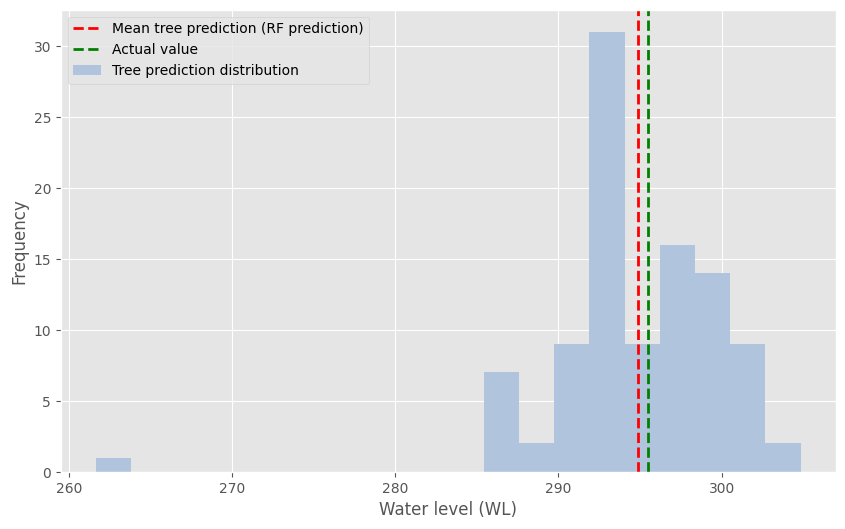

In [14]:
# Get the individual tree predictions for the first test sample
test_sample_input = X_test.iloc[0].values.reshape(1, -1)
test_sample_output = y_test.iloc[0].values
individual_tree_predictions = [tree.predict(test_sample_input).item() for tree in model_default.estimators_]

# Plot the distribution of individual tree predictions
plt.figure(figsize=(10, 6))
plt.hist(individual_tree_predictions, bins=20, color='lightsteelblue')
plt.axvline(np.mean(individual_tree_predictions), color='red', linestyle='dashed', linewidth=2)
plt.axvline(test_sample_output, color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Water level (WL)')
plt.ylabel('Frequency')
plt.legend(['Mean tree prediction (RF prediction)', 'Actual value', 'Tree prediction distribution'])
plt.show()

In a random forest, individual trees can overestimate or underestimate certain data points because each tree is trained on a random subset of features, and on a random set of measurements sampled with replacement. Hence the randomness in the forest! By doing this we try to obtain diversity in our estimators, making the RF model more generalizable, as each tree has seen subtly different scenarios that might be useful for future predictions. While the mean is the most popular aggregation method, there are alternatives for aggregating tree predictions. For example, using the median instead can make the model even more robust to outliers, at the cost of flexibility in predictions.

By combining predictions from multiple trees and taking the average, random forests become less susceptible to overfitting and more robust to outliers. We are essentially making a **double average**, first in the leaf nodes of the trees, and then again when aggregating tree predictions, which causes a smoothing effect on the noisy tree predictions. This is generally good, but it also means it becomes be very hard (if not impossible) for RF to predict extreme values, and it is by design unable to extrapolate; for areas outside the training range it will simply give the same output as in the group of data in the closest boundary.

### Feature importance

A very useful feature to understand Random Forest's predictions is the feature importance. With decision trees we could directly see which variables were more important, as they appeared more often and higher in the hierarchy. When we aggregate many trees, the model becomes more obscure and we cannot directly asses it.

Hoewever, RF provides a built-in feature importance that checks what variables reduce the most error on average. These can be easily visualized by accessing *.feature_importances_* in the model.

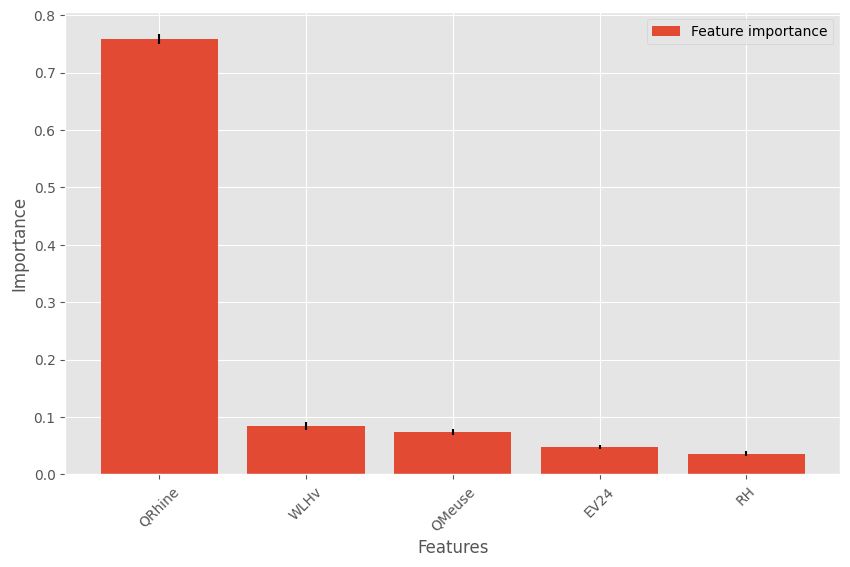

In [18]:
# Plot the most important features with standard deviation
importances = model_default.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_default.estimators_], axis=0)
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align='center', label='Feature importance')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.show()

The absolute value is not really important, but rather the comparison between them and the variability between trees. We also plotted the standard deviation between importances in each tree with a black line at the top of each bar. So, as we already saw with the simple tree model, the QRhine is by far the most important variable with very low standard deviations.

While there are other ways to obtain feature importance, this one does is not require any extra computation and is extremely easy to use and understand. Come to the next workshop to learn more about feature importance!

## 1.4 Effect of hyperparameters

Our model performs fine with default parameters, but there is room for improvement. To address this, we can try to tune the model hyperparameters. We will delve deeper into how to do this efficiently in a future workshop but, for now, we will manually evaluate a few combinations to see their effect on the model's performance.

For example, we can lower *max_depth* of the trees. We will call this the 'tuned' model. We check again the R squared value to compare it to the default model.

In [20]:
# Define and fit the 'tuned' RF model
model_hyperparameter_v1 = RandomForestRegressor(max_depth=3,  random_state=42)
model_hyperparameter_v1.fit(X_train.values, y_train.values.ravel())
rf_prediction_hyper_v1 = model_hyperparameter_v1.predict(X_test.values)

# Predict for the test data and evaluate results
score_hyper_v1 = r2_score(y_test, rf_prediction_hyper_v1)
print(f'R2 cofficient for default RF model: {score_default}')
print(f'R2 cofficient for tunned model: {score_hyper_v1}')

R2 cofficient for default RF model: 0.7041006193207535
R2 cofficient for tunned model: 0.6959954147916267


Our tuned model performed a bit worse than the default model. To get a better idea of what is going on, let's visualize the results.

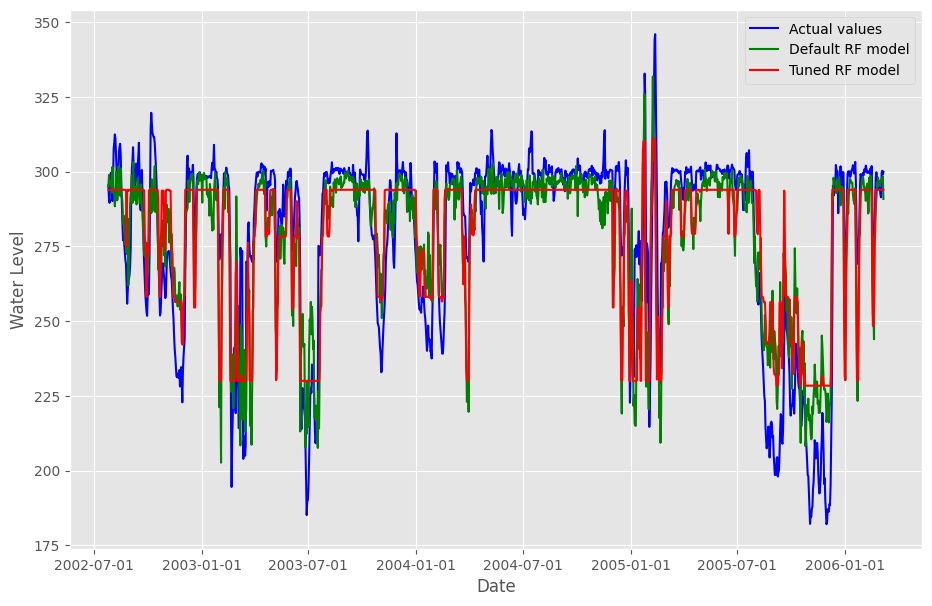

In [21]:
import matplotlib.dates as mdates

plt.figure(figsize=(11, 7))
plt.plot(y_test.index, y_test, label='Actual values', color='b')
plt.plot(y_test.index, rf_prediction_default, label='Default RF model', color='g')
plt.plot(y_test.index, rf_prediction_hyper_v1, label='Tuned RF model', color='r')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

We can see that, by reducing the depth of the trees in our RF, we lower the amount of outcomes that our model can predict, and this causes our results to look kind of 'blocky' in comparison.

In ML terms, we can say that the model has become more biased, meaning that we might not be able to capture the full complexity of the problem. On the other hand it could help to avoid overfitting, that is, learning non-generalizable features from the training data. To learn more about overfitting and how to prevent it stay up to date for coming workshops!

### Tuning n_estimators

Now, let's go back to the hyperparameters. Another important one is the number of estimators. In that case, the higher the better, but that also will cost us computational resources. The good news, is that the performance improvement becomes less and less as the number of estimators grow.

To check what value we are comfortable with, we will try a few values, and calculate the **OOB error**. The Out Of Bag error is a cheap way to estimate validation error by predicting the training values only with the individual trees that were not trained on them. As you may remember, each tree is fed only a certain percentage of the training data sampled with replacement. Therefore, we can use the subset of trees that did not get a certain sample to predict it for every sample in the training data, essentially testing the performance on new data without needing more than the training one.

Keep in mind that because we are not predicting with all the trees, the OOB error is not a replacement for proper model evaluation. However, we can still use it to compare results between models for hyperparameter tuning, as we do in here.

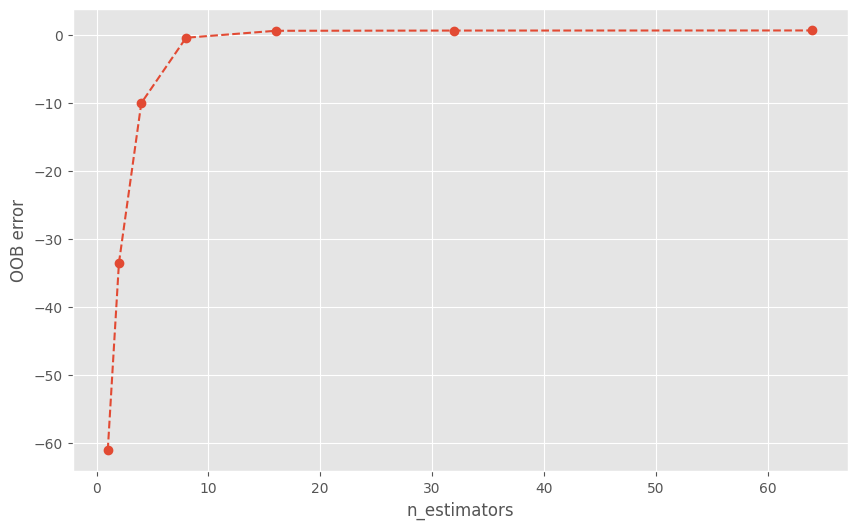

In [22]:
import warnings

# Define an array of n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64]

# Create an empty list to store the results
results = []

# Loop over the different values of n_estimators
for estimator in n_estimators:
    # Filter annoying errors ;)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        model = RandomForestRegressor(n_estimators=estimator, max_samples=0.8,
                                      oob_score=True, random_state=42)
        # Fit a tree and store its oob score
        model.fit(X_train.values, y_train.values.ravel())
        results.append(model.oob_score_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, results, marker='o', linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB error')
plt.show()

Again, the absolute values are not important, just the comparison between them. In this case, the higher the score the better. We can see that there is a large improvement for the first few values, but the increase in performance becomes negligible after n_estimators=16. So we can just run the model with 16 estimators, saving a lot of time and memory (if we want to store the model).

### Tuning guide for RF

As we have seen, changing the hyperparameters can have quite a big impact on the model's performance an computational impact. To simplify the process of finding the right hyperparameters, we have compiled a table explaining what you should aim for in each of them.

| Category             | Hyperparameter       | Description                                         | Default Value         | Tuning Advice                                 | Example Tuning Range                                   |
|----------------------|----------------------|-----------------------------------------------------|-----------------------|-----------------------------------------------|----------------------------------------------------------|
| Tree-specific        | `max_depth`          | Maximum depth of the trees.                         | `None` (unlimited)      | Decrease to control complexity and overfitting. | 3 to 30, or until no improvement.                         |
|                      | `min_samples_split`  | Minimum samples required at a decision node.        | `2`                     | Increase to control overfitting.               | 2 to 20, consider dataset size.                           |
|                      | `min_samples_leaf`   | Minimum samples required at a leaf node.            | `1`                     | Increase to control overfitting.               | 1 to 20, consider dataset size.                           |
| Bagging-related      | `n_estimators`       | Number of trees in the forest.                      | `100`                    | Adjust based on performance and computational limits. | 100 to 1000 trees                                         |
|                      | `max_samples`        | Samples to draw from X to train each tree.          | `None` (all samples)    | Adjust based on dataset size and variance.   | 0.6 to 0.95 of the dataset.                                |
|                      | `max_features`       | Number of features to consider at each split.       | `1.0` (all features)  | Decrease to reduce variance. | around `log2(n_features)` or `n_features/3`.                        |


Keep in mind that it is very difficult to give general advice on the tuning ranges, as each task may require very different hyperparameters. Also, it can become quite computationally expensive to tune multiple hyperparameters, so one needs to decide which to give priority to based on the specifics of the task. This is why it is so important to learn more about ML models ;)

## 1.5 Final remarks

Well, we have learnt a lot about Random forest in this session. Now it is time for you to practice a bit more with them. For example, you could try to tune one of the other hyperparameters in the table, and see its effect in the predictions. Feel free to copy-paste code from the previous chapters!

In [ ]:
# Set hyperparameter values to tune


# Train a model for each of these values (and store it!)



In [ ]:
# Plot OOB error to compare the performance



In [ ]:
# Plot the predictions of the stored models on the test data

